In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [8]:
def evaluate_tensor_network(A, B, C, D, config):
    # given matrices A, B, C, D and a config (dict with keys i, j, k, l), return the prod
    # A[i, j] * B[j, k] * C[k, l] * D[l, i]
    i, j, k, l = config['i'], config['j'], config['k'], config['l']
    return A[i, j] * B[j, k] * C[k, l] * D[l, i]

In [9]:
def update_config(A, B, C, D, config, idx, n):
    # update the config at index idx (one of ijkl) with the conditional distribution (Glauber)
    # the conditional distr is proportial to the factors that depend on the index

    if idx == 'i':
        j, l = config['j'], config['l']
        vals = np.array([A[i_prime, j] * D[l, i_prime] for i_prime in range(n)])
    elif idx == 'j':
        i, k = config['i'], config['k']
        vals = np.array([A[i, j_prime] * B[j_prime, k] for j_prime in range(n)])
    elif idx == 'k':
        j, l = config['j'], config['l']
        vals = np.array([B[j, k_prime] * C[k_prime, l] for k_prime in range(n)])
    elif idx == 'l':
        k, i = config['k'], config['i']
        vals = np.array([C[k, l_prime] * D[l_prime, i] for l_prime in range(n)])
    else:
        raise ValueError('not ijkl')
    
    probs = vals / np.sum(vals)
    new_val = np.random.choice(np.arange(n), p=probs)
    return new_val


In [10]:
def mcmc_trace(A, B, C, D, n, iters=10000, discards=1000):
    # estimate Tr(ABCD) using MCMC Glauber random walk over the index configs as the state space
    # state space is the set of all index configs (i, j, k, l), size is n^4
    # weight function w(i, j, k, l) = A[i, j]B[j, k]C[k, l]D[l, i] the contraction value is tr(ABCD)
    # = sum(i, j, k, l) w(i, j, k, l)
    # using Glauber dynamics for updating, each step we update a randomly chosen index according to the conditional distribution

    config = {
        'i' : np.random.randint(0, n),
        'j' : np.random.randint(0, n),
        'k' : np.random.randint(0, n),
        'l' : np.random.randint(0, n)
    }
    curr_val = evaluate_tensor_network(A, B, C, D, config)
    samples = []
    indices = ['i', 'j', 'k', 'l']

    for t in range(iters):
        idx = np.random.choice(indices) # randomly choose an index to update
        new_val = update_config(A, B, C, D, config, idx, n) # update the config using cond distr.
        config[idx] = new_val

        curr_val = evaluate_tensor_network(A, B, C, D, config) # eval new config

        if t >= discards:
            samples.append(curr_val) # store the value of the contraction after discards
    
    mean_samples = np.mean(samples)
    trace_estimate = mean_samples * n**4

    return trace_estimate

def exact_trace(A, B, C, D):
    # compute the exact trace of the tensor network contraction
    return np.einsum('ij,jk,kl,li->', A, B, C, D)

In [11]:
def run_trials(dims, iters=100000, discards=1000):
    mc_estimates = []
    exact_values = []
    errors = []
    runtimes = []
    
    for n in dims:
        # positive (entrywise) random matrices
        A = np.abs(np.random.randn(n, n))
        B = np.abs(np.random.randn(n, n))
        C = np.abs(np.random.randn(n, n))
        D = np.abs(np.random.randn(n, n))

        ex_trace = exact_trace(A, B, C, D)

        start = time.time()
        mc_trace = mcmc_trace(A, B, C, D, n, iters=iters, discards=discards)
        runtime = time.time() - start

        error = np.abs(mc_trace - ex_trace)
        
        mc_estimates.append(mc_trace)
        exact_values.append(ex_trace)
        errors.append(error)
        runtimes.append(runtime)

        print(f'n = {n:>3}: Exact = {ex_trace:.4f}, MC = {mc_trace:.4f}, Error = {error:.4f}, Time = {runtime:.4f}s')
    
    return dims, mc_estimates, exact_values, errors, runtimes

n =   2: Exact = 5.6091, MC = 14.6614, Error = 9.0523, Time = 3.0051s
n =   4: Exact = 127.4156, MC = 732.6626, Error = 605.2470, Time = 3.2832s
n =   8: Exact = 1542.0524, MC = 8596.8209, Error = 7054.7686, Time = 3.3019s
n =  16: Exact = 26069.9615, MC = 150037.1546, Error = 123967.1931, Time = 3.5623s
n =  32: Exact = 455710.1827, MC = 2720580.3875, Error = 2264870.2048, Time = 4.2212s
n =  64: Exact = 6870945.4368, MC = 41645503.7589, Error = 34774558.3221, Time = 5.3859s
n = 128: Exact = 107893488.6792, MC = 644048612.2940, Error = 536155123.6148, Time = 7.9547s


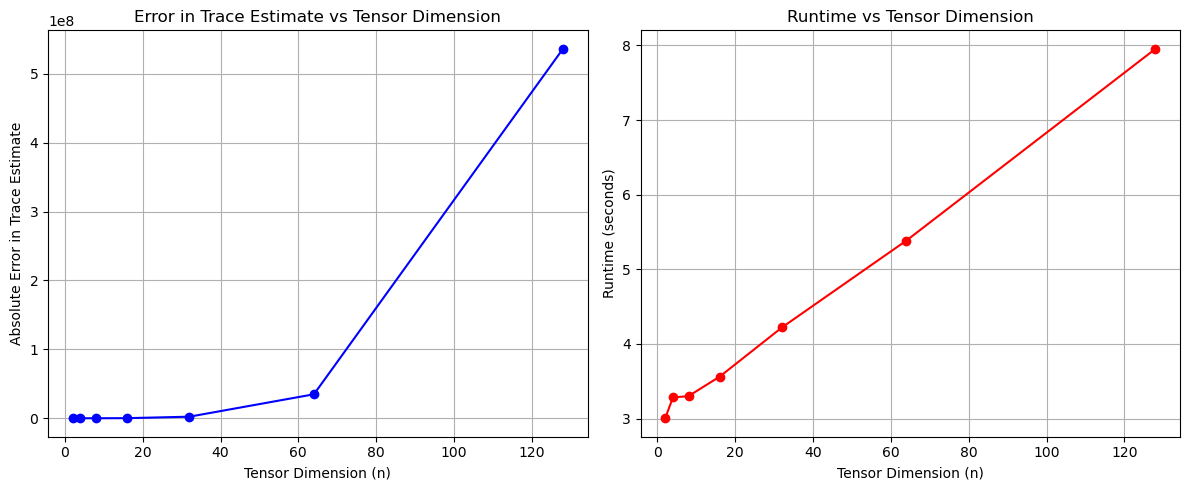

In [12]:
dimensions = [2, 4, 8, 16, 32, 64, 128]
dims, mc_estimates, exact_values, errors, runtimes = run_trials(dimensions, iters=100000, discards=1000)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dimensions, errors, marker='o', linestyle='-', color='blue')
plt.xlabel('Tensor Dimension (n)')
plt.ylabel('Absolute Error in Trace Estimate')
plt.title('Error in Trace Estimate vs Tensor Dimension')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(dimensions, runtimes, marker='o', linestyle='-', color='red')
plt.xlabel('Tensor Dimension (n)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Tensor Dimension')
plt.grid(True)

plt.tight_layout()
plt.show()